dog.jpg exists
torch.Size([3, 1365, 2048])


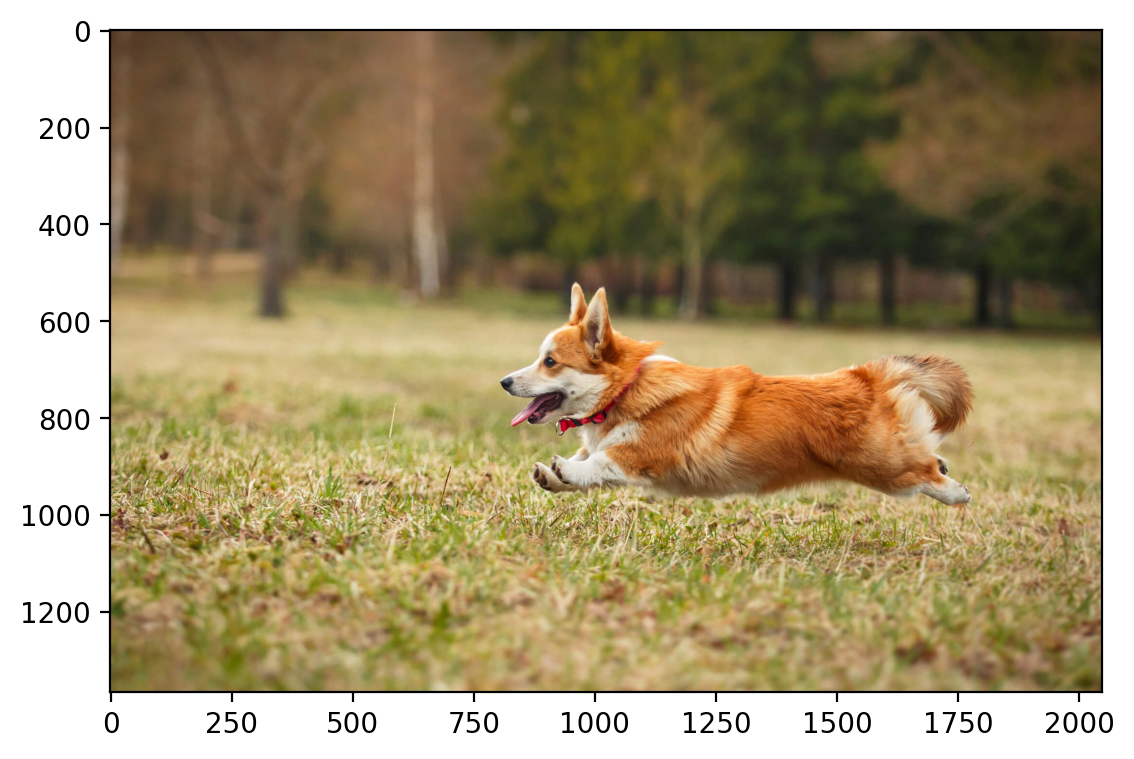

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '2'
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy()) # Simply rearanging the data as many librariries require h w c.


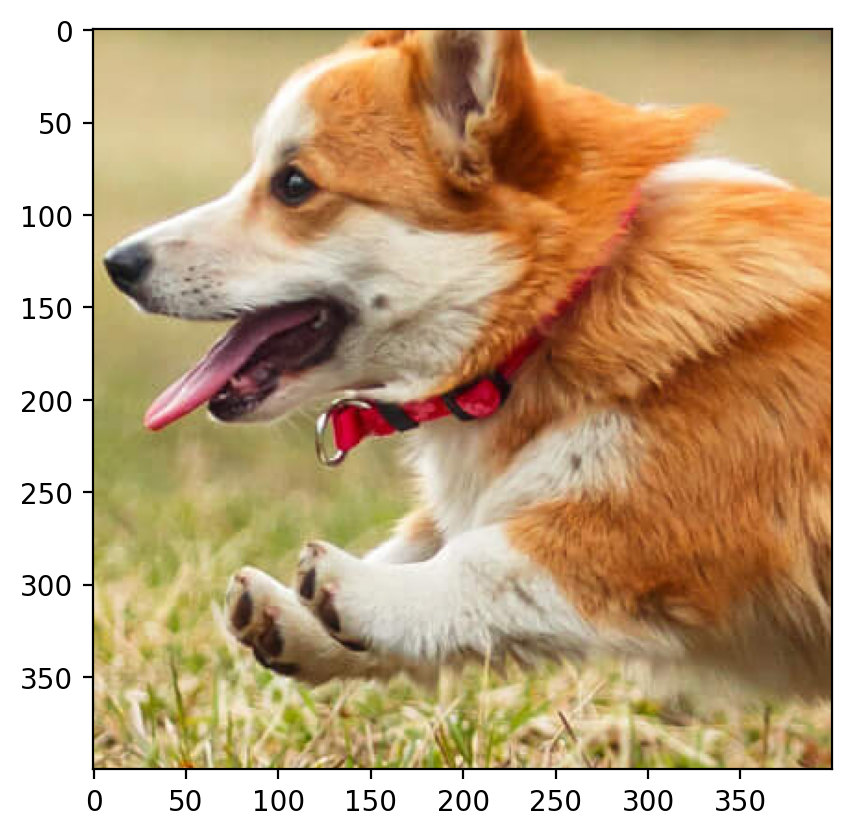

In [2]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape # No shape change.

img_scaled = torch.tensor(img_scaled)

crop_400 = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
crop_400.shape

resized_crop_200 = torchvision.transforms.functional.resize(crop_400, (200, 200))

plt.imshow(rearrange(crop_400, 'c h w -> h w c').cpu().numpy())

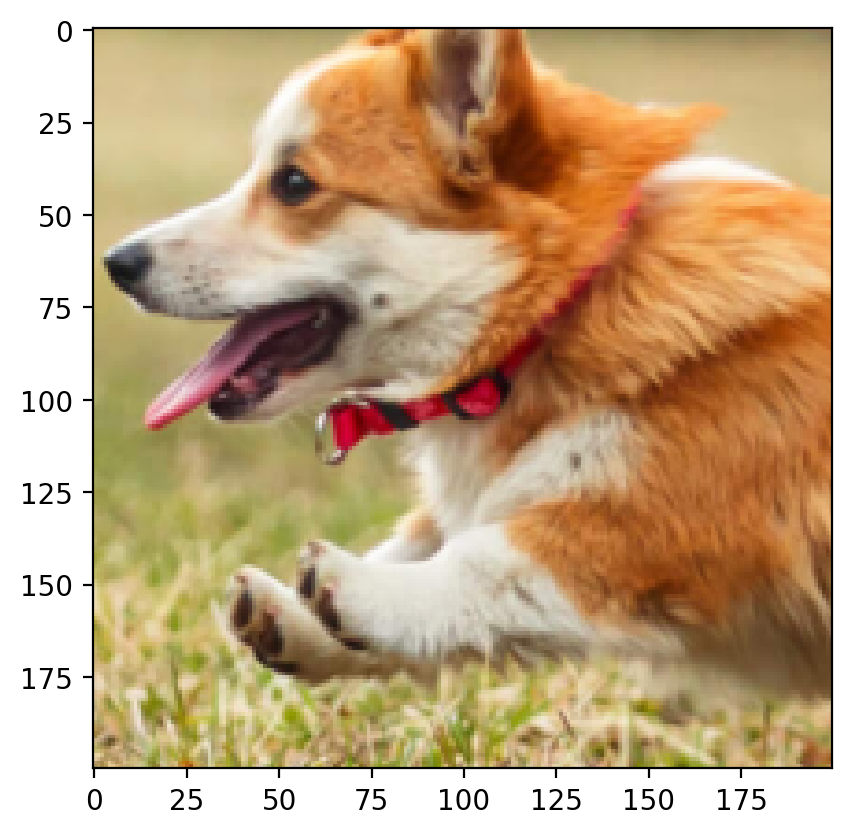

In [3]:
plt.imshow(rearrange(resized_crop_200, 'c h w -> h w c').cpu().numpy())


In [4]:
# Get the dimensions of the image tensor
num_channels, height, width = crop_400.shape
print(num_channels, height, width)

3 400 400


In [5]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    # X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [6]:
dog_X, dog_Y = create_coordinate_map(crop_400) # Done only to get the the dog_X mesh.

dog_X.shape, dog_Y.shape

# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [7]:
import numpy as np
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)
    
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()


def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")

    print("Size of Reconstructed image: ", outputs.shape)


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

    return outputs

def calculate_rmse(pred, GT):
    # Ensure the images have the same shape
    assert pred.shape == GT.shape, "Images must have the same shape"

    # Calculate the squared differences
    squared_diff = np.square(pred - GT)

    # Calculate the mean of squared differences
    mean_squared_diff = np.mean(squared_diff)

    # Calculate the square root to get the RMSE
    rmse = np.sqrt(mean_squared_diff)

    return rmse


def calculate_psnr(pred, GT, max_pixel_value=255):
    # Ensure the images have the same shape
    assert pred.shape == GT.shape, "Images must have the same shape"

    # Calculate the mean squared error
    mse = np.mean(np.square(pred - GT))

    # Calculate the PSNR using the formula: PSNR = 20 * log10(max_pixel_value / sqrt(mse))
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))

    return psnr


In [8]:
# making the dog image
resized_crop_200 = torchvision.transforms.functional.resize(crop_400, (200, 200))
resized_crop_200 = resized_crop_200.to(device)
dog_X_200, dog_Y_200 = create_coordinate_map(resized_crop_200)

dog_Y_200.shape

torch.Size([40000, 3])

In [9]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


In [10]:
num_features = 30000
X_rff = create_rff_features(dog_X_scaled, num_features, 0.008)

In [11]:
X_rff.shape

torch.Size([160000, 30000])

In [12]:
# Now we need to 2x super resolution. So...
X_rff_train = []
for i in range(0,400):
  if (i%2 != 0):
    continue
  for j in range(0,400,2):
    X_rff_train.append(X_rff[i*400 + j])


X_rff_train = torch.stack(X_rff_train)
X_rff_train = X_rff_train.to(device)
print("Train shape:",X_rff_train.shape)
Y_train = dog_Y_200 # 200 X 200 image
X_rff_evaluate = X_rff

Train shape: torch.Size([40000, 30000])


In [13]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

X_rff_train = X_rff_train.to(device)
Y_train = Y_train.to(device)    

train(net, 0.005, X_rff_train, Y_train, 2500)

Epoch 0 loss: 0.365319


Epoch 100 loss: 0.042675
Epoch 200 loss: 0.007805
Epoch 300 loss: 0.003699
Epoch 400 loss: 0.002254
Epoch 500 loss: 0.001459
Epoch 600 loss: 0.000971
Epoch 700 loss: 0.000656
Epoch 800 loss: 0.000449
Epoch 900 loss: 0.000315
Epoch 1000 loss: 0.000229
Epoch 1100 loss: 0.000175
Epoch 1200 loss: 0.000142
Epoch 1300 loss: 0.000123
Epoch 1400 loss: 0.000112
Epoch 1500 loss: 0.000105
Epoch 1600 loss: 0.000101
Epoch 1700 loss: 0.000099
Epoch 1800 loss: 0.000098
Epoch 1900 loss: 0.000097
Epoch 2000 loss: 0.000096
Epoch 2100 loss: 0.000096
Epoch 2200 loss: 0.000095
Epoch 2300 loss: 0.000095
Epoch 2400 loss: 0.000094


9.40036479732953e-05

In [14]:
torch.save(net.state_dict(), 'linear_model.pth')
### Then to evaluate again ###
model = LinearModel(X_rff.shape[1], 3)
model.load_state_dict(torch.load('linear_model.pth'))

# Set the model to evaluation mode
model.eval()

crop_400  =crop_400.to(device)
X_rff = X_rff.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size of the input train image:  torch.Size([200, 200, 3])
Size of Reconstructed image:  torch.Size([400, 400, 3])


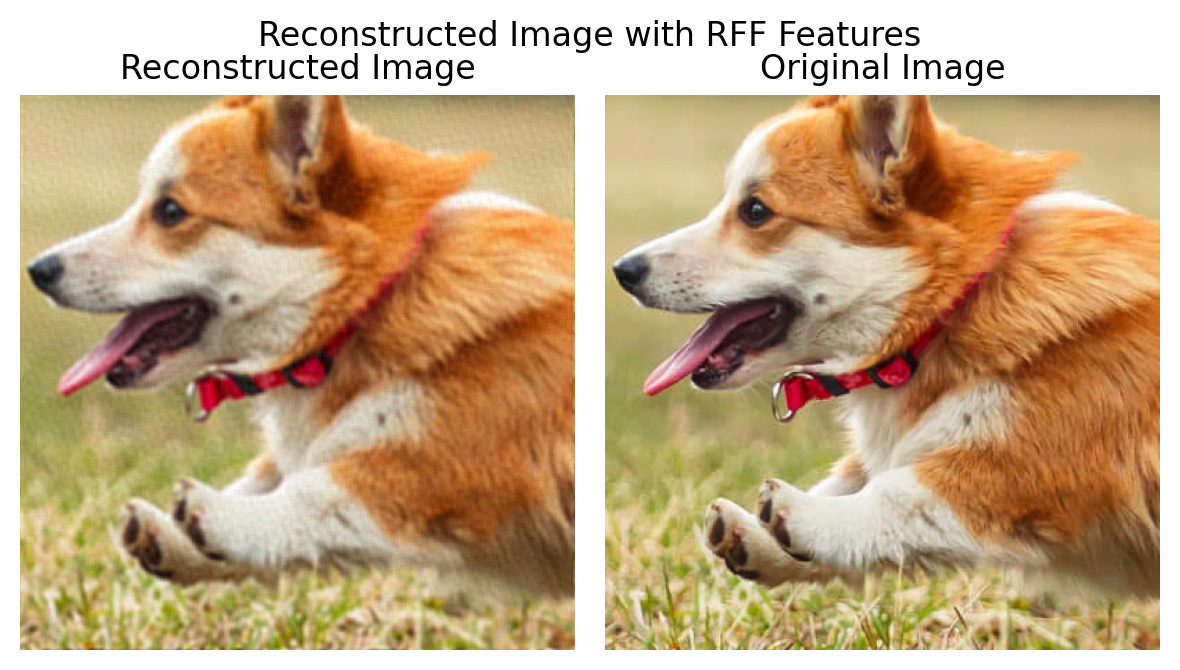

In [15]:
print("Size of the input train image: ", resized_crop_200.shape[-1::-1])
outputs = plot_reconstructed_and_original_image(crop_400, net, X_rff, title="Reconstructed Image with RFF Features") 

In [17]:
rmse_value = calculate_rmse(outputs, crop_400)
psnr_value = calculate_psnr(outputs, crop_400)

print('---------------------------------------')
print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")

---------------------------------------
RMSE: 0.29368636833144535
PSNR: 58.773127830815845
